# Task 1 Result Analysis

This notebook contains the main data analysis of the models' results. It includes tables and figures to understand the differences in performances of all models and compute the mean across folds.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("c:\\Users\\nerea\\OneDrive\\Documentos\\EPFL_MASTER\\PDM\\Project\\PyalData")
# to change for the actual path where PyalData has been cloned

In [3]:
from pyaldata import *

In [4]:
name = 'Chewie'
date = '1007'
fold = 0
target_variable = 'vel'

In [5]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [6]:
to_t_eval =  lambda array: torch.tensor(array, device=device, dtype=dtype)  

## Load pre-processed data

In [7]:
data_path = './Data/Processed_Data/Tidy_'+name+'_'+date+'.pkl'

with open(data_path, 'rb') as file:
    tidy_df = pickle.load(file)

In [8]:
baseline_df = tidy_df.loc[tidy_df['epoch'] == 'BL']

In [9]:
baseline_df.id.nunique()

170

In [10]:
force_df =  tidy_df.loc[tidy_df['epoch'] == 'AD']

We need to consider only the trials for which the monkey has already adapted to the perturbation.

In [11]:
ids_to_keep = force_df.id.unique()[50:]

The baseline subset has a total of 170 trials, whereas the perturbation one contains 201 trials, we can for now try to remove the first 50 trials from the perturbation subset.

In [12]:
force_df = force_df.loc[force_df.id.isin(ids_to_keep)]

## Loading models

In [13]:
path_to_models = './Models/Models_Force'

In [14]:
subsets = [baseline_df, force_df, tidy_df]
subsets_str = ['Baseline', 'Adaptation', 'All'] 

In [15]:
models = []
folds = []
EV = []
R2 = []
y_pred = []
y_true = []
data = []

subsets = [baseline_df, force_df, tidy_df]

for m in os.listdir(path_to_models):
    path_model = os.path.join(path_to_models,m)
    for f in os.listdir(path_model):
        fold_num = f[5]
        path_fold = os.path.join(path_model, f)  
        model = torch.load(path_fold)
        model.eval()
        for s, str_s in zip(subsets, subsets_str):
            _,_,_,_, x_test, y_test, _,_,info_test,_,_ = get_dataset(s, fold_num,
                                                                     target_variable= target_variable, 
                                                                     no_outliers = False, force_data = True)
            
            y_true_test, y_pred_test = reshape_to_eval(x_test,y_test, model)
            ev = explained_variance_score(y_true_test, y_pred_test)
            r2 = r2_score(y_true_test, y_pred_test)
            models.append(m)
            folds.append(f[:-4])
            data.append(str_s)
            EV.append(ev)
            R2.append(r2)
            y_pred.append([y_pred_test])
            y_true.append([y_true_test])

Test trials  34
Val trials 27
We are testing the optimization method on fold  4
Test trials  30
Val trials 24
We are testing the optimization method on fold  4
Test trials  66
Val trials 53
We are testing the optimization method on fold  4
Test trials  34
Val trials 27
We are testing the optimization method on fold  0
Test trials  30
Val trials 24
We are testing the optimization method on fold  0
Test trials  66
Val trials 53
We are testing the optimization method on fold  0
Test trials  34
Val trials 27
We are testing the optimization method on fold  1
Test trials  30
Val trials 24
We are testing the optimization method on fold  1
Test trials  66
Val trials 53
We are testing the optimization method on fold  1
Test trials  34
Val trials 27
We are testing the optimization method on fold  2
Test trials  30
Val trials 24
We are testing the optimization method on fold  2
Test trials  66
Val trials 53
We are testing the optimization method on fold  2
Test trials  34
Val trials 27
We are tes

In [75]:
# Create a DataFrame
results_df = pd.DataFrame({
    'Model': models,
    'Dataset': data,
    'Fold': folds,
    'EV': EV,
    'R2': R2,
    'Y_pred': y_pred,
    'Y_true': y_true
})

In [78]:
# Function to extract the desired part of the model name
def extract_model_name(name):
    if name.split('_')[-2] == 'after':
        return '_'.join(name.split('_')[-3:])
    
    name_ =  name.split('_')[-1]
    if 'hnet' in name:
        name_ = str(name_)+'_hnet'
    return(name_)

In [79]:
results_df['Model'] = results_df.Model.apply(lambda x: extract_model_name(x))

In [80]:
results_df

,Model,Dataset,Fold,EV,R2,Y_pred,Y_true
0,Baseline_hnet,Baseline,fold_4,0.884186,0.884157,"[[[-2.0903835, -2.9135146], [-1.1939449, -2.33...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
1,Baseline_hnet,Adaptation,fold_4,0.581557,0.573810,"[[[0.12896407, 0.03987214], [0.48268223, 0.140...","[[[-0.55927455, -0.65708464], [-0.32793257, -0..."
2,Baseline_hnet,All,fold_4,0.718144,0.717005,"[[[-1.4613484, -3.887565], [-0.54206884, -1.71...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
3,Baseline_hnet,Baseline,fold_0,0.860055,0.860030,"[[[1.8731725, -0.9627352], [0.3273012, -0.8717...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
4,Baseline_hnet,Adaptation,fold_0,0.632969,0.631748,"[[[0.8585064, 0.52941144], [3.7736192, 1.60264...","[[[-0.9787036, -1.2993112], [0.30494222, -0.50..."
...,...,...,...,...,...,...,...
115,Baseline,Adaptation,fold_2,0.528838,0.524481,"[[[0.38363394, -0.15016033], [0.5670341, -0.20...","[[[0.2390867, 0.25198182], [0.31185794, 0.3840..."
116,Baseline,All,fold_2,0.747303,0.746239,"[[[0.5021202, -0.23423794], [1.6779425, -0.888...","[[[0.87900066, 0.94454104], [0.46398437, 0.702..."
117,Baseline,Baseline,fold_3,0.872815,0.871818,"[[[-0.04268892, -0.35597682], [-0.38529038, -1...","[[[-0.005129213, 0.011146309], [-0.39050233, -..."
118,Baseline,Adaptation,fold_3,0.490397,0.487979,"[[[1.7948658, -0.84997827], [3.635188, -2.1312...","[[[-0.07894559, -1.1707562], [-0.28758198, -1...."


In [81]:
results_df.Model.unique()

array(['Baseline_hnet', 'Alldata', 'EWC', 'Force_hnet',
       'Force_after_Baseline', 'Baseline_after_Force', 'Force',
       'Baseline'], dtype=object)

In [82]:
results_df_filt = results_df.loc[results_df.Dataset != 'All']

In [83]:
import seaborn as sns

In [87]:
models_test_baseline = ['Baseline', 'Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Baseline_hnet', 'Alldata'] 

models_test_adaptation = ['Force', 'Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Force_hnet', 'Alldata'] 

In [94]:
results_df_baseline = results_df.loc[(results_df.Dataset == 'Baseline')& results_df.Model.isin(models_test_baseline)]
results_df_adaptation = results_df.loc[(results_df.Dataset == 'Adaptation')& results_df.Model.isin(models_test_adaptation)]

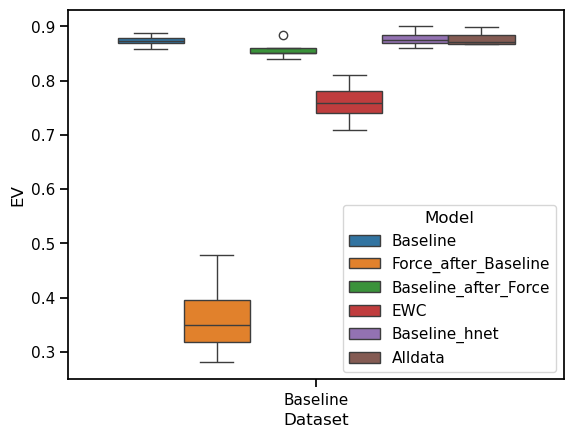

In [97]:
hue_order = ['Baseline', 'Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Baseline_hnet',  'Alldata']  # Add other model names in the desired order


sns.boxplot(x='Dataset', y='EV', hue = 'Model', data=results_df_baseline, hue_order = hue_order)
plt.show()

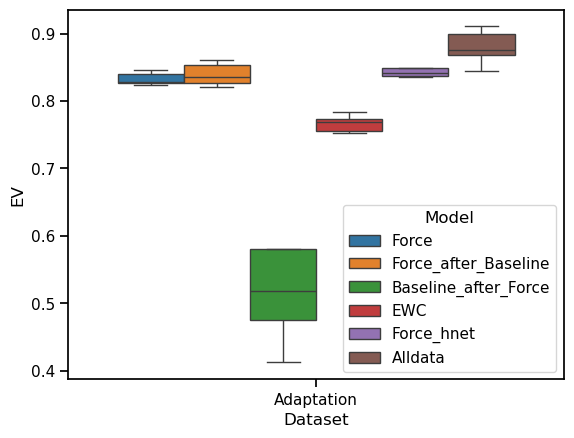

In [98]:
hue_order = [ 'Force','Force_after_Baseline',
             'Baseline_after_Force','EWC',
             'Force_hnet', 'Alldata']  # Add other model names in the desired order


sns.boxplot(x='Dataset', y='EV', hue = 'Model', data=results_df_adaptation, hue_order = hue_order)
plt.show()